1. Token level perplexity in training set |

In [1]:
import os, torch 
from model import GPT, GPTConfig 

# Data Filter Issue: Missing character & number & symbols 
# - desired character set: 
all_chars = '''abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ ⏎'''

device = "cpu"
out_dir = "checkpoint/base"
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)

model = GPT.load_model(checkpoint, device)

number of parameters: 10.66M


/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_17681/2830301627.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_locat

In [2]:
# load tokenizer functional 
load_meta = False
init_from = 'resume'
import pickle
if init_from == 'resume' and 'config' in checkpoint and 'dataset' in checkpoint['config']: # older checkpoints might not have these...
    meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
    load_meta = os.path.exists(meta_path)
if load_meta:
    print(f"Loading meta from {meta_path}...")
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    # TODO want to make this more general to arbitrary encoder/decoder schemes
    stoi, itos = meta['stoi'], meta['itos']
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])

Loading meta from data/enwiki/meta.pkl...


Dynamic Tokenizer

In [16]:
from src.etoken import ETokenizer 

tok = ETokenizer(char_vocab=itos)
tok.add_tokens([[1,2]]) # add token groups 
tok.remove_tokens([90]) # remove merged tokens (other than base character token)
encode = lambda s: tok.encode(s)
decode = lambda l: tok.decode(l)

 :: Adding new token:   !  with idx:  90
 :: Removed tokens:  [90]


In [18]:
import torch 
from src.utils import calculate_bits_per_char

text = "DeepSeek's architectural innovations MoE, MLA, MTP, and FP3Quantization focus on optimizing largescale training and deployment and serving efficiency."

token_ids = torch.tensor(encode(text)).view(1, -1)
input_ids, target_ids = token_ids[:, :-1], token_ids[:, 1:]
logits, token_loss = model(input_ids, targets=target_ids, reduction='none') # loss is provided as an 'average' loss per token --- I want singular loss per token 
bpc_loss = calculate_bits_per_char(token_loss, target_ids, decode)

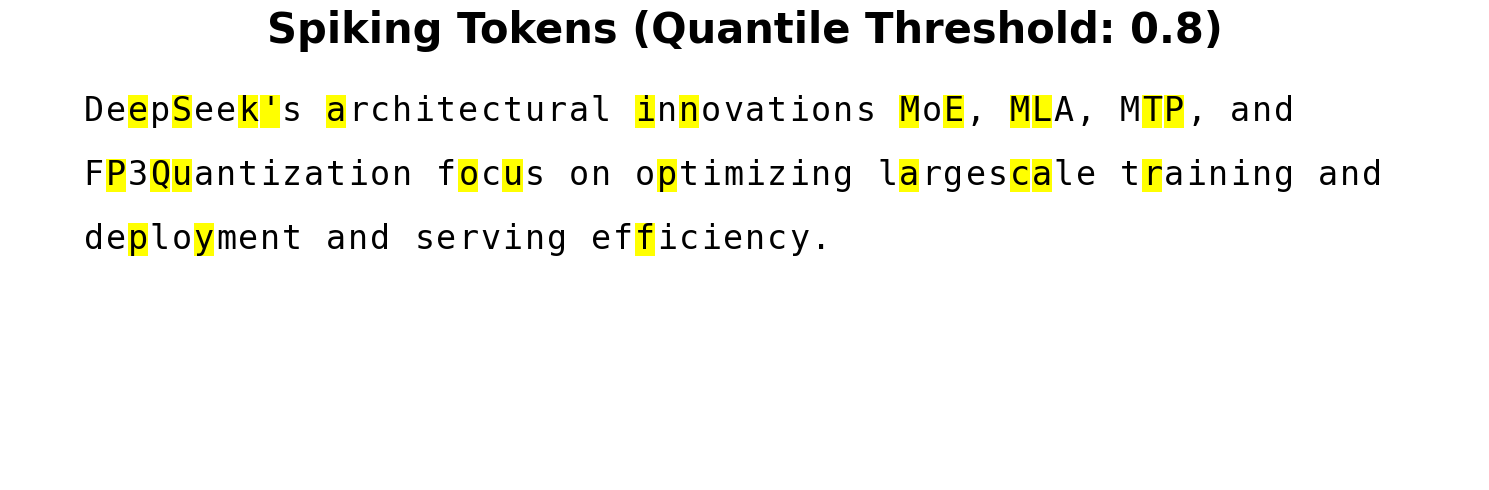

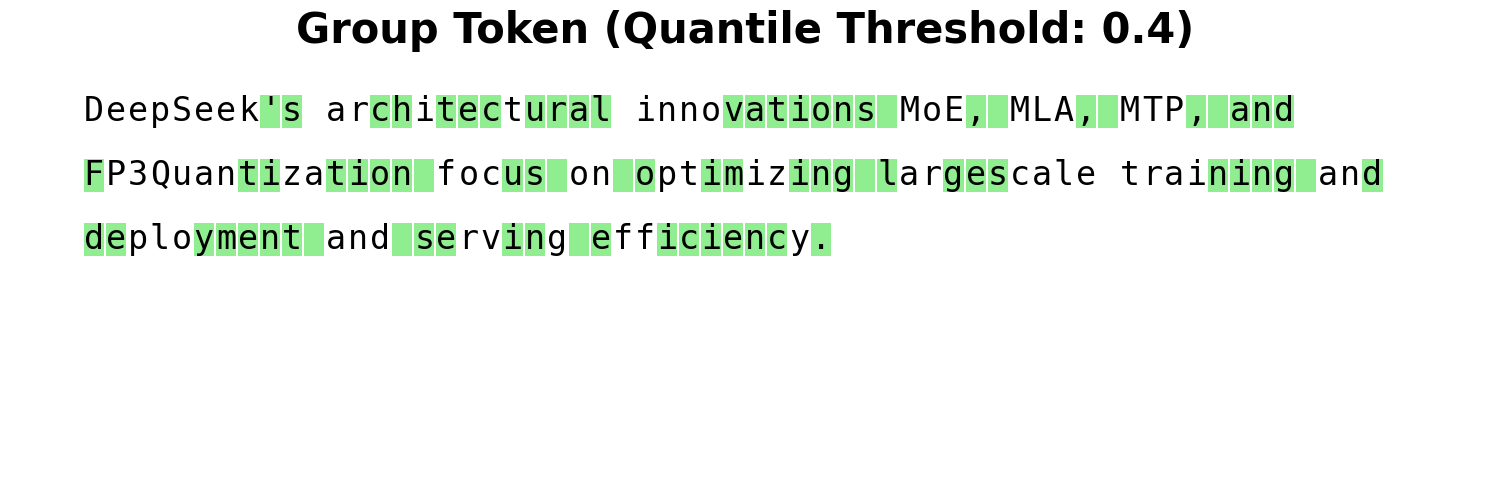

In [20]:
from src.vis import display_colored_text
from src.utils import shift_token_loss, map_token_to_char_perplexity, get_naive_char_color

token_perplexity = shift_token_loss(token_loss)
char_perplexity = map_token_to_char_perplexity(text, token_ids, token_perplexity, decode)

from src.grouping import get_spike_token_mask, get_group_token_mask

# (a). Spiking token visualization 
spike_quantile_threshold = 0.80
spike_token_mask = get_spike_token_mask(token_perplexity, quantile_threshold=spike_quantile_threshold)
char_perplexity, char_colors = map_token_to_char_perplexity(text, token_ids, token_perplexity, decode, spike_token_mask, mask_color='yellow')
display_colored_text(text, char_colors, title=f"Spiking Tokens (Quantile Threshold: {spike_quantile_threshold})")

# (b). Group token visualization 
group_quantile_threshold = 0.4
group_token_mask = get_group_token_mask(token_perplexity, quantile_threshold=group_quantile_threshold)
char_perplexity, char_colors = map_token_to_char_perplexity(text, token_ids, token_perplexity, decode, group_token_mask, mask_color='lightgreen')
display_colored_text(text, char_colors, title=f"Group Token (Quantile Threshold: {group_quantile_threshold})")

In [4]:
# Quantile threshold for logit loss values
quantile_threshold = 0.80
loss_threshold = torch.quantile(token_loss, 0.80)

# IDEA 1. Just to train a different tokenization base on the CharLM performance, and see if it improve performance
# ... Continuous morphing of tokenization scheme during training ...
# 'Merge tokens with similar embeddings'
# 'Spike in perplexity --> breaking token (if it's continuous)'
# 'Continuous Drop in perplexity --> merge tokens (if there are multiple tokens)'

# (a). Embedding similarity 
def detect_embedding_similarity(token_loss, quantile_threshold=0.80): 
    raise NotImplementedError


In [6]:
# Change tokenization scheme according to spike & group tokens 

from src.grouping import detect_group_token, detect_spike_token
import tiktoken 

# (a). Spike token 
tokens_to_split = detect_spike_token(token_ids, token_perplexity, quantile_threshold=spike_quantile_threshold)

# (b). Group token 
tokens_to_group = detect_group_token(token_ids, token_perplexity, quantile_threshold=group_quantile_threshold)

# (c). Special tokenizer class allowing for : 
#    - 1. custom initialization 
#    - 2. cutom token merging 
#    - 3. custom token splitting

# (d). Dynamically training LLM with tokenizer update 